# Music Generation with RNNs

In this portion of the lab, we will explore building a Recurrent Neural Network (RNN) for music generation using 
PyTorch. We will train a model to learn the patterns in raw sheet music in [ABC notation](https://en.wikipedia.org/wiki/ABC_notation) and then use this model to generate new music.

NOTE: See LSTM Music generation notes after the RNN model pic for more explanations

In [ ]:
# !pip install comet_ml > /dev/null 2>&1
import comet_ml
COMET_API_KEY = "YOUR API KEY" 

# Import PyTorch and other relevant libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Download and import the MIT Introduction to Deep Learning package
# !pip install mitdeeplearning --quiet
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
from scipy.io.wavfile import write
# !apt-get install abcmidi timidity > /dev/null 2>&1


# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert torch.cuda.is_available(), "Please enable GPU from runtime settings"
assert COMET_API_KEY != "", "Please insert your Comet API Key"

2025-10-20 16:16:58.269487: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


## 2.2 Dataset

We've gathered a dataset of thousands of Irish folk songs, represented in the ABC notation. Let's download the dataset and inspect it:


In [2]:
# Download the dataset
songs = mdl.lab1.load_training_data()

# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [1]:
# Convert the ABC notation to audio file and listen to it
# mdl.lab1.play_song(example_song)

One important thing to think about is that this notation of music does not simply contain information on the notes being played, but additionally there is meta information such as the song title, key, and tempo. How does the number of different characters that are present in the text file impact the complexity of the learning problem? This will become important soon, when we generate a numerical representation for the text data.

In [4]:
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs)
print(len(songs_joined))

vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

200679
There are 83 unique characters in the dataset


## 2.3 Process the dataset for the learning task

Let's take a step back and consider our prediction task. We're trying to train an RNN model to learn patterns in ABC music, and then use this model to generate (i.e., predict) a new piece of music based on this learned information.

Breaking this down, what we're really asking the model is: given a character, or a sequence of characters, what is the most probable next character? We'll train the model to perform this task.

To achieve this, we will input a sequence of characters to the model, and train the model to predict the output, that is, the following character at each time step. RNNs maintain an internal state that depends on previously seen elements, so information about all characters seen up until a given moment will be taken into account in generating the prediction.

# Vectorize the text

Before we begin training our RNN model, we'll need to create a numerical representation of our text-based dataset. To do this, we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters. Recall that we just identified the unique characters present in the text.


In [5]:
### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d",
#   we can evaluate `char2idx["d"]`.
char2idx = {u: i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)

In [6]:
print('{')
for char, _ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [ ]:
### Vectorize the songs string ###
def vectorize_string(string):
    """Convert a string into a numeric vector using char2idx mapping."""
    string_vector = np.array([char2idx[s] for s in string], dtype=np.int32)
    return string_vector

vectorized_songs = vectorize_string(songs_joined)

In [8]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


### Create training examples and targets

Our next step is to actually divide the text into example sequences that we'll use during training. Each input sequence that we feed into our RNN will contain `seq_length` characters from the text. We'll also need to define a target sequence for each input sequence, which will be used in training the RNN to predict the next character. For each input, the corresponding target will contain the same length of text, except shifted one character to the right.

To do this, we'll break the text into chunks of `seq_length+1`. Suppose `seq_length` is 4 and our text is "Hello". Then, our input sequence is "Hell" and the target sequence is "ello".

The batch method will then let us convert this stream of character indices to sequences of the desired size.

In [ ]:
### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
    # the length of the vectorized songs string
    n = vectorized_songs.shape[0] - 1
    # randomly choose the starting indices for the examples in the training batch
    idx = np.random.choice(n - seq_length, batch_size)

    input_batch = [vectorized_songs[i : i + seq_length] for i in idx]

    output_batch = [vectorized_songs[i + 1 : i + seq_length + 1] for i in idx]

    # # Convert the input and output batches to tensors
    x_batch = torch.tensor(input_batch, dtype=torch.long)
    y_batch = torch.tensor(output_batch, dtype=torch.long)

    return x_batch, y_batch

# # Perform some simple tests to make sure your batch function is working properly!
test_args = (vectorized_songs, 10, 2)
x_batch, y_batch = get_batch(*test_args)
assert x_batch.shape == (2, 10), "x_batch shape is incorrect"
assert y_batch.shape == (2, 10), "y_batch shape is incorrect"
print("Batch function works correctly!")


Batch function works correctly!


/tmp/ipykernel_367009/3830148394.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  x_batch = torch.tensor(input_batch, dtype=torch.long)


For each of these vectors, each index is processed at a single time step. So, for the input at time step 0, the model receives the index for the first character in the sequence, and tries to predict the index of the next character. At the next timestep, it does the same thing, but the RNN considers the information from the previous step, i.e., its updated state, in addition to the current input.

We can make this concrete by taking a look at how this works over the first several characters in our text:


In [10]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(x_batch[0], y_batch[0])):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx.item()])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx.item()])))

Step   0
  input: 43 (np.str_('R'))
  expected output: 70 (np.str_('o'))
Step   1
  input: 70 (np.str_('o'))
  expected output: 56 (np.str_('a'))
Step   2
  input: 56 (np.str_('a'))
  expected output: 59 (np.str_('d'))
Step   3
  input: 59 (np.str_('d'))
  expected output: 1 (np.str_(' '))
Step   4
  input: 1 (np.str_(' '))
  expected output: 75 (np.str_('t'))


## 2.4 The Recurrent Neural Network (RNN) model

Now we're ready to define and train an RNN model on our ABC music dataset, and then use that trained model to generate a new song. We'll train our RNN using batches of song snippets from our dataset, which we generated in the previous section.

The model is based off the LSTM architecture, where we use a state vector to maintain information about the temporal relationships between consecutive characters. The final output of the LSTM is then fed into a fully connected linear [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer where we'll output a softmax over each character in the vocabulary, and then sample from this distribution to predict the next character.

As we introduced in the first portion of this lab, we'll be using PyTorch's [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) to define the model. Three components are used to define the model:

* [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html): This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with `embedding_dim` dimensions.
* [`nn.LSTM`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html): Our LSTM network, with size `hidden_size`.
* [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html): The output layer, with `vocab_size` outputs.

<img src="https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/2019/lab1/img/lstm_unrolled-01-01.png" alt="Drawing"/>



<!--
Now we're ready to define and train a RNN model on our ABC music dataset, and then use that trained model to generate a new song. We'll train our RNN using batches of song snippets from our dataset, which we generated in the previous section.

The model is based off the LSTM architecture, where we use a state vector to maintain information about the temporal relationships between consecutive characters. The final output of the LSTM is then fed into a fully connected [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer where we'll output a softmax over each character in the vocabulary, and then sample from this distribution to predict the next character.

As we introduced in the first portion of this lab, we'll be using the Keras API, specifically, [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential), to define the model. Three layers are used to define the model:

* [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with `embedding_dim` dimensions.
* [`tf.keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): Our LSTM network, with size `units=rnn_units`.
* [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with `vocab_size` outputs.


<img src="https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/2019/lab1/img/lstm_unrolled-01-01.png" alt="Drawing"/> -->

# LSTM Music Generation - Notes

### Assumptions
- **Vocab size** = 83  
- **Batch size** = 32  
- **LSTM hidden units** = 128  
- **Embedding size** = 256  
- **Sequence length** = 100  

---

### 1️⃣ Encoding the Input
After combining all the music texts, the vocabulary size is 83.  
- One option: represent each symbol as a **one-hot vector**.  
- Better option: use a **PyTorch embedding layer**, which maps each symbol (integer index) to a **dense, learnable vector**.  
- Embedding size is a hyperparameter — here we chose 256, **not necessarily equal to the vocab size**.

---

### 2️⃣ Creating Training Sequences and Labels
- Randomly select **starting indices** in the joined songs text.  
- For each starting index, take a **sequence of length 100** as the **input sequence**.  
- The **target sequence** is the **next 100 symbols**, i.e., shifted by one position.  
- Repeat 32 times → **batch of 32 sequences** of length 100.

---

### 3️⃣ Feeding Input to the Model
- The **full input sequence** is fed to the model at once, shape `(batch_size, seq_length)` → `(32, 100)`.  
- Each symbol passes through the **embedding layer** → shape `(batch_size, seq_length, embedding_dim)` → `(32, 100, 256)`.  
- The **LSTM layer** processes the entire sequence internally:
  - Updates **hidden and cell states** at each time step.  
  - Produces outputs for all time steps at once → shape `(batch_size, seq_length, hidden_size)` → `(32, 100, 128)`.  
- The **fully connected layer** maps the LSTM outputs to vocabulary probabilities → `(batch_size, seq_length, vocab_size)` → `(32, 100, 83)`.

---

### 4️⃣ State Propagation
- The LSTM keeps **hidden and cell states** which are carried forward between time steps.  
- This allows the model to capture **temporal dependencies** across the sequence.

---

### 5️⃣ Loss Computation and Backpropagation
- Compute **loss over the entire sequence** comparing predicted outputs and target sequences.  
- `loss.backward()` performs **backpropagation through time (BPTT)**, automatically accumulating gradients across all time steps.  
- `optimizer.step()` updates the **shared weights** of the embedding, LSTM, and FC layers.  

---

### ✅ Key Points / Clarifications
- Embedding size **≠ vocab size**; it’s a tunable hyperparameter.  
- Input to embedding layer is **indices**, not one-hot vectors.  
- Target sequence is offset by **one time step**, not “plus one numeric index.”  
- **All time steps are processed in one forward pass**; gradients are accumulated across the sequence during BPTT.  
- Sequence length is consistent for both input and target.

### Define the RNN model

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def init_hidden(self, batch_size, device):
        return (torch.zeros(1, batch_size, self.hidden_size).to(device),
                torch.zeros(1, batch_size, self.hidden_size).to(device))

    def forward(self, x, state=None, return_state=False):
        x = self.embedding(x)  # (batch, seq_len, emb_dim)
        if state is None:
            state = self.init_hidden(x.size(0), x.device)

        out, state = self.lstm(x, state)  # (batch, seq_len, hidden_size)
        out = self.fc(out)                # (batch, seq_len, vocab_size)
        
        return out if not return_state else (out, state)
    
    

In [12]:
# Instantiate the model! Build a simple model with default hyperparameters. You
#     will get the chance to change these later.
vocab_size = len(vocab)
embedding_dim = 256
hidden_size = 1024
batch_size = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(vocab_size, embedding_dim, hidden_size).to(device)

# print out a summary of the model
print(model)

LSTMModel(
  (embedding): Embedding(83, 256)
  (lstm): LSTM(256, 1024, batch_first=True)
  (fc): Linear(in_features=1024, out_features=83, bias=True)
)


In [13]:
# Test the model with some sample data
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
x = x.to(device)
y = y.to(device)

pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       torch.Size([32, 100])  # (batch_size, sequence_length)
Prediction shape:  torch.Size([32, 100, 83]) # (batch_size, sequence_length, vocab_size)


In [14]:
sampled_indices = torch.multinomial(torch.softmax(pred[0], dim=-1), num_samples=1)
sampled_indices = sampled_indices.squeeze(-1).cpu().numpy()
sampled_indices

array([42, 28, 16, 61, 17, 16, 39, 28, 24, 79, 59, 80,  0, 11, 15, 43, 53,
       79, 42, 15, 55,  1, 41, 52, 21, 75, 63,  6,  9, 54, 29, 30, 52, 14,
       75, 66, 61, 36, 15, 61, 50,  6, 38, 60, 44, 34, 12, 29, 29, 79, 11,
       35, 54, 51, 64, 26, 48, 40, 77, 47,  6, 64, 79, 32, 70, 27, 14, 39,
       27, 66, 31,  9, 26, 11, 39,  2, 70, 30, 42, 55,  5, 80, 68, 55, 48,
       68, 12, 72, 29, 33, 62, 29, 72, 31, 69, 22, 22, 55,  2, 56])

In [15]:
print("Input: \n", repr("".join(idx2char[x[0].cpu()])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 'ilt\nZ: id:dc-reel-99\nM:C\nL:1/8\nK:D Major\nB|A3F ABde|fedc dBB2|AFF2 ABde|fedc d3:|!\ne|faa2 bafb|afef '

Next Char Predictions: 
 "QC4f54NC=xdy\n/3R]xQ3_ P[9th(-^DE[2tkfK3fY(MeSI0DDx/J^ZiAWOvV(ixGoB2NBkF-A/N!oEQ_'ym_Wm0qDHgDqFn::_!a"


As you can see, the text predicted by the untrained model is pretty nonsensical! How can we do better? Well, we can train the network!

## 2.5 Training the model: loss and training operations

Now it's time to train the model!

At this point, we can think of our next character prediction problem as a standard classification problem. Given the previous state of the RNN, as well as the input at a given time step, we want to predict the class of the next character -- that is, to actually predict the next character.

To train our model on this classification task, we can use a form of the `crossentropy` loss (i.e., negative log likelihood loss). Specifically, we will use PyTorch's [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), as it combines the application of a log-softmax ([`LogSoftmax`](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax)) and negative log-likelihood ([`NLLLoss`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) in a single class and accepts integer targets for categorical classification tasks. We will want to compute the loss using the true targets -- the `labels` -- and the predicted targets -- the `logits`.

Let's define a function to compute the loss, and then use that function to compute the loss using our example predictions from the untrained model.

In [16]:
### Defining the loss function ###

#     the true labels and predictions (logits). '''

cross_entropy = nn.CrossEntropyLoss() # instantiates the function
def compute_loss(labels, logits):
    """
    Inputs:
      labels: (batch_size, sequence_length)
      logits: (batch_size, sequence_length, vocab_size)

    Output:
      loss: scalar cross entropy loss over the batch and sequence length
    """

    # Batch the labels so that the shape of the labels should be (B * L,)
    batched_labels = labels.view(-1)

    vocab_size = logits.shape[2]
    batched_logits = logits.reshape(-1, vocab_size)

    loss = cross_entropy(batched_logits, batched_labels)
    return loss

In [ ]:
### compute the loss on the predictions from the untrained model from earlier. ###
y.shape  # (batch_size, sequence_length)
pred.shape  # (batch_size, sequence_length, vocab_size)

example_batch_loss = compute_loss(y, pred) 

print(f"Prediction shape: {pred.shape} # (batch_size, sequence_length, vocab_size)")
print(f"scalar_loss:      {example_batch_loss.mean().item()}")

Prediction shape: torch.Size([32, 100, 83]) # (batch_size, sequence_length, vocab_size)
scalar_loss:      4.420446872711182


In [18]:
### Hyperparameter setting and optimization ###

vocab_size = len(vocab)

# Model parameters:
params = dict(
  num_training_iterations = 3000,  # Increase this to train longer
  batch_size = 8,  # Experiment between 1 and 64
  seq_length = 100,  # Experiment between 50 and 500
  learning_rate = 5e-3,  # Experiment between 1e-5 and 1e-1
  embedding_dim = 256,
  hidden_size = 1024,  # Experiment between 1 and 2048
)

# Checkpoint location:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")
os.makedirs(checkpoint_dir, exist_ok=True)

In [19]:
### Create a Comet experiment to track our training run ###

def create_experiment():
  # end any prior experiments
  if 'experiment' in locals():
    experiment.end()

  # initiate the comet experiment for tracking
  experiment = comet_ml.Experiment(
                  api_key=COMET_API_KEY,
                  project_name="6S191_Lab1_Part2")
  # log our hyperparameters, defined above, to the experiment
  for param, value in params.items():
    experiment.log_parameter(param, value)
  experiment.flush()

  return experiment


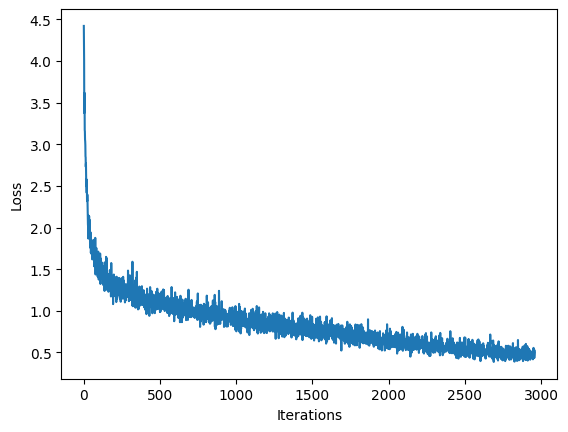

100%|██████████| 3000/3000 [00:56<00:00, 52.70it/s]
COMET INFO: Uploading 6576 metrics, params and output messages
COMET INFO: Waiting for remaining data to be uploaded to Comet. 6 messages remaining.


True

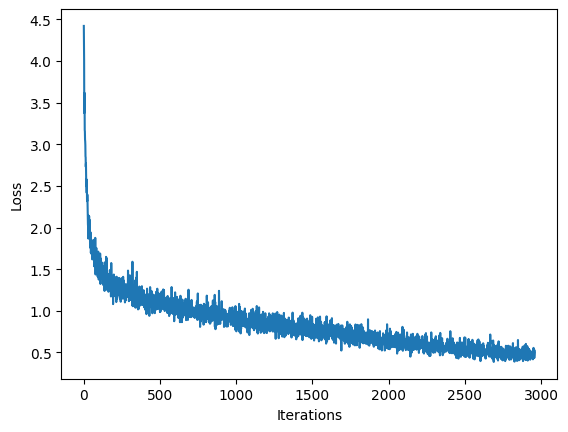

In [ ]:
### Define optimizer and training operation ###

vocab_size = len(vocab)
embedding_dim = 256
hidden_size = 1024
model = LSTMModel(vocab_size, embedding_dim, hidden_size)

# Move the model to the GPU
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_step(x, y):
  # Set the model's mode to train
  model.train()

  # Zero gradients for every step
  optimizer.zero_grad()

  # Forward pass
  y_hat = model(x)

  # Compute the loss
  loss = compute_loss(y, y_hat)

  # Backward pass
  loss.backward()
  optimizer.step()

  return loss

##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
experiment = create_experiment()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for iter in tqdm(range(params["num_training_iterations"])):

    # Grab a batch and propagate it through the network
    x_batch, y_batch = get_batch(vectorized_songs, params["seq_length"], params["batch_size"])

    # Convert numpy arrays to PyTorch tensors
    x_batch = torch.tensor(x_batch, dtype=torch.long).to(device)
    y_batch = torch.tensor(y_batch, dtype=torch.long).to(device)

    # Take a train step
    loss = train_step(x_batch, y_batch)

    # Log the loss to the Comet interface
    experiment.log_metric("loss", loss.item(), step=iter)

    # Update the progress bar and visualize within notebook
    history.append(loss.item())
    plotter.plot(history)

    # Save model checkpoint
    if iter % 100 == 0:
        torch.save(model.state_dict(), checkpoint_prefix)

# Save the final trained model
torch.save(model.state_dict(), checkpoint_prefix)
experiment.flush()


In [22]:
def generate_text(model, start_string, generation_length=1000):
    # Convert start string to indices
    input_idx = torch.tensor([[char2idx[s] for s in start_string]], dtype=torch.long).to(device)

    # Initialize hidden state
    state = model.init_hidden(input_idx.size(0), device)

    # Store generated text
    text_generated = list(start_string)
    tqdm._instances.clear()

    for i in tqdm(range(generation_length)):
        # Forward pass
        predictions, state = model(input_idx, state, return_state=True)

        # Take only the last timestep
        predictions = predictions[:, -1, :]  # (batch, vocab_size)
        probs = torch.softmax(predictions, dim=-1)

        # Sample next character
        input_idx = torch.multinomial(probs, num_samples=1)  # (batch, 1)

        # Convert to character and append
        predicted_char = idx2char[input_idx.item()]
        text_generated.append(predicted_char)

    return ''.join(text_generated)

In [23]:
# Execute the function to generate text
generated_text = generate_text(model, "X", 1000)
print(generated_text)

100%|██████████| 1000/1000 [00:00<00:00, 3729.44it/s]

X:25
T:Boys of Grevsomust
Z: id:dc-reel-210
M:C
L:1/8
K:G Major
D2|GABG AGEG|c3A B2AB|cAFA G2FG|AGFA G2:|!
AG|FGAF GBAG|F2AF GFGB|A2FA G2eg|fdcA BGAF|!
DGG2 DGBd|GBdg ecAF|GBdB cAFG|(3ABA GF G2:|!
dg|fded cAAe|fdge fdec|dfeg fdAF|GBAG FDDe|!
fded cAA2|fdd2 fded|Add2 fd^cd|efge ^d2Ad|!
d2fd fdfd|ed^cd efge|afge defd|gabg eged|]!

X:73
T:Ducky's
Z: id:dc-jig-112
M:6/8
L:1/8
K:D Major
Bc|dFF2 AFDF|Addc dcBA|BdcA BdcB|ABcd BGG2:|!
dgbg agfd|cABG AGEG|DGG2 AGAB|c3A B2d2|!
efg2 efge|d2cA GEE2|D2FA GFD2|de (3cde (3fgf (3ece|f2df e2ce|dcBA F2F2|!
a2f2 g2fe|d2g2 e2g2|f4 e2e2|f4
E|F2F2 GEDF|A2ce dcBA|G2A2 G3A|G2FA G4|]!

X:268
T:New Chipzer
Z: id:dc-reel-171
M:C
L:1/8
K:D Major
A2FA DAFA|B2AF EFGB|AFDE FDAB|c3B cdef|!
g2fg edBc|dcBA F2A2|gfed cBAG|F2E2 E2:|!
FG|A2GA BAGF|GABc d2de|f2ed cBAc|d2f2 d2:|!
fe|d2fd c2ec|d2cB cBAG|(3Bcd cBAG|F2 A2F|EDB,A, D4|]!

X:8
T:Duke of Leinster
Z: id:dc-slipjig-11
M:9/8
L:1/8
K:D Mixolydian
E|FED EFG|ABG FEF|G3 G2D|GAG Gdc|!
B2G A2G|FDF AGF|G3 G2E|EGFE D2:|!
FA|

In [2]:
### Play back generated songs ###

# generated_songs = mdl.lab1.extract_song_snippet(generated_text)

# for i, song in enumerate(generated_songs):
#   # Synthesize the waveform from a song
#   waveform = mdl.lab1.play_song(song)

#   # If its a valid song (correct syntax), lets play it!
#   if waveform:
#     print("Generated song", i)
#     ipythondisplay.display(waveform)

#     numeric_data = np.frombuffer(waveform.data, dtype=np.int16)
#     wav_file_path = f"output_{i}.wav"
#     write(wav_file_path, 88200, numeric_data)

#     # save your song to the Comet interface -- you can access it there
#     experiment.log_asset(wav_file_path)

In [25]:
# when done, end the comet experiment
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : sorry_deer_9807
COMET INFO:     url                   : https://www.comet.com/fahimeh-baftizadeh/6s191-lab1-part2/2b685f370cd642b7b4c9ebc92f5e9d91
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [3300] : (0.3627433776855469, 4.420782566070557)
COMET INFO:   Parameters:
COMET INFO:     batch_size              : 8
COMET INFO:     embedding_dim           : 256
COMET INFO:     hidden_size             : 1024
COMET INFO:     learning_rate           : 0.005
COMET INFO:     num_training_iterations : 3000
COMET INFO:     seq_length              : 100
COMET INFO:   Uploads:
COMET INFO:     asset                        : 3 (31.46 MB)
COMET INFO: 